# Korean MRC Baseline

## Dependency
다음과 같은 라이브러리를 사용한다.
- [Konlpy](https://konlpy.org/ko/latest/index.html): 파이썬 한국어 NLP 처리기
- [Mecab-korean](https://bitbucket.org/eunjeon/mecab-ko-dic/src): 한국어 형태소 분석기

In [1]:
! apt-get install -y openjdk-8-jdk python3-dev
! pip install konlpy "tweepy<4.0.0"
! /bin/bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-dev is already the newest version (3.6.7-1~18.04).
python3-dev set to manually installed.
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libxxf86dga1 openjdk-8-jdk-headless openjdk-8-jre
  openjdk-8-jre-headless x11-utils
Suggested packages:
  gvfs openjdk-8-demo openjdk-8-source visualvm icedtea-8-plugin libnss-mdns
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic mesa-utils
The following NEW packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libxxf86dga1 openjdk-8-jdk openjdk-8-jdk-headless
  openjdk-8-jre openjdk-8-jre-headless x11-utils
0 upgraded,

In [2]:
!pip install wandb

     |████████████████████████████████| 1.8 MB 4.2 MB/s 
     |████████████████████████████████| 144 kB 70.5 MB/s 
     |████████████████████████████████| 181 kB 69.8 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=baf5e6ff562e29272fb55fabecb3bf6f24761b52e0064d996d4324afa4b92a7d
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [3]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## 데이터셋 구성
현재 JSON 데이터를 볼 수 있는 클래스를 하나 작성하자.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


`load` 메소드를 이용해서 Json 데이터를 불러올 수 있다.

In [32]:
from typing import List, Tuple, Dict, Any
import json
import random

class KoMRC:
    def __init__(self, data, indices: List[Tuple[int, int, int]]):
        self._data = data
        self._indices = indices

    # Json을 불러오는 메소드
    @classmethod
    def load(cls, file_path: List, add_data = 0):  # file_path를 list로 받아서, 기존 kaggle data외에 데이터도 load 
        first_path = file_path[0]
        n = 0
        for path in file_path:
            if path == first_path: # 첫번째 path를 제외하고 data dict 안에 list로 붙여줌 
                with open(path, 'r', encoding='utf-8') as fd:
                    data = json.load(fd)
            else:
                with open(path, 'r', encoding='utf-8') as fd:
                    data_tmp = json.load(fd)
                    for item in data_tmp['data']: # data딕셔너리 안에 list만 넣어줌
                        data['data'].append(item)
                        n += 1
                        if n==add_data: # 추가되는 데이터수를 조정
                            break

        indices = []
        for d_id, document in enumerate(data['data']):
            for p_id, paragraph in enumerate(document['paragraphs']):
                unique_check = paragraph['qas'][0]['answers'] # 중복되는 질문과 답은 2개까지만 허용(데이터 수가 너무 많아짐)
                for q_id, qas in enumerate(paragraph['qas']):             
                    if qas['answers'] == unique_check and q_id > 1:
                        break
                    indices.append((d_id, p_id, q_id))

        return cls(data, indices)

    # 데이터 셋을 잘라내는 메소드
    @classmethod
    def split(cls, dataset, eval_ratio: float=.1, seed=42):
        indices = list(dataset._indices)
        random.seed(seed)
        random.shuffle(indices)
        train_indices = indices[int(len(indices) * eval_ratio):]
        eval_indices = indices[:int(len(indices) * eval_ratio)]

        return cls(dataset._data, train_indices), cls(dataset._data, eval_indices)

    def __getitem__(self, index: int) -> Dict[str, Any]:
        d_id, p_id, q_id = self._indices[index]
        paragraph = self._data['data'][d_id]['paragraphs'][p_id]

        context = paragraph['context']
        qa = paragraph['qas'][q_id]

        try:
            guid = qa['guid']
        except KeyError:
            guid = self._data['data'][d_id]['content_id'] # 새로운 데이터셋에서 guid라는 tag가 없기때문에 다른것을 붙여줌
        question = qa['question']
        answers = qa['answers']

        return {
            'guid': guid,
            'context': context,
            'question': question,
            'answers': answers
        }

    def __len__(self) -> int:
        return len(self._indices)


In [6]:
drive_path = '/content/drive/MyDrive/k-digital-goorm-3-korean-mrc/'

In [7]:
#dataset = KoMRC.load([drive_path + 'train.json', drive_path + '도서.json'], 301)  # file_path list 안에 path들을 다 넣어줌. 
#print("Number of Samples:", len(dataset))
#print(dataset[0])

`split` 메소드를 이용하면 데이터 셋을 나눌 수 있다.

In [38]:
#train_dataset, dev_dataset = KoMRC.split(dataset)
#print("Number of Train Samples:", len(train_dataset))
#print("Number of Dev Samples:", len(dev_dataset))
#print(dev_dataset[0])

Number of Train Samples: 37836
Number of Dev Samples: 4203
{'guid': '8f7b55b4381d4eac927c42a44ea7d64c', 'context': '마리사 메이어 야후 최고경영자(CEO)가 언급한 에어비엔비(Airbnb)와 태스크래빗(TaskRabbit)에 관심이 쏠리고 있다. 에어비엔비는 숙박 공유 서비스이고 태스크래빗은 심부름 알선 서비스다. 두 업체의 공통점은 사용하지 않는 공간이나 물건, 지식, 노동력 등을 나눠 쓰는 ‘공유경제’ 개념을 기반으로 한다는 것이다. 미국 시사 주간지 타임은 지난해 ‘세상을 변화시킬 10가지 아이디어’ 가운데 하나로 ‘공유’를 꼽았다.에어비엔비는 2007년 미국 샌프란시스코에서 설립된 회사다. 월세를 내지 못해 허덕이던 룸메이트 브라이언 체스키(32)와 조 게비아(32)가 샌프란시스코에서 열린 대형 디자인 콘퍼런스 참가자들에게 돈을 받고 거실을 빌려준 것이 시작이었다.홈페이지나 스마트폰 앱을 통해 저렴한 비용으로 다른 이용자의 빈방에 숙박할 수 있고, 반대로 자신의 주거 공간을 빌려줄 수도 있다. 출장이나 긴 여행으로 집을 비우게 될 경우 쌈짓돈을 벌거나, 사용하지 않는 방을 세 놓는 데 쓸 수도 있다. 이미 192개국 4300여개 도시에서 35만개에 달하는 숙소가 등록돼 운영되고 있다. 세계 각지에 퍼진 네트워크로 특히 해외 여행객들에게 인기가 있다. 태스크래빗은 일종의 단기 아르바이트 중개 서비스로 ‘퍼스널 아웃소싱’이라는 개념을 탄생시켰다. 설립자인 리 부스케(35)는 어느 날 강아지 사료가 떨어진 것을 보고 가게까지 다녀오기가 귀찮아 심부름을 대신해줄 사람을 주위에서 쉽게 구할 수 있는 인터넷 사이트가 있으면 좋겠다고 생각했다. IBM 소프트웨어 엔지니어였던 그는 2008년 이 구상을 구체화해 태스크래빗을 설립했다.', 'question': '샌프란시스코에서 만들어진 회사에서 제공하는 서비스는?', 'answers': [{'text': '숙박 공유', 'ans

단어 단위로 토큰화해서 정답 위치를 찾기 위하여 토큰화 및 위치 인덱싱을 하는 클래스를 상속을 통해 작성해 보자.

In [8]:
from typing import Generator
import konlpy

class TokenizedKoMRC(KoMRC):
    def __init__(self, data, indices: List[Tuple[int, int, int]]) -> None:
        super().__init__(data, indices)
        self._tagger = konlpy.tag.Mecab()

    def _tokenize_with_position(self, sentence: str) -> List[Tuple[str, Tuple[int, int]]]:
        position = 0
        tokens = []
        for morph in self._tagger.morphs(sentence):
            position = sentence.find(morph, position)
            tokens.append((morph, (position, position + len(morph))))
            position += len(morph)
        return tokens
            
    def __getitem__(self, index: int) -> Dict[str, Any]:
        sample = super().__getitem__(index)

        context, position = zip(*self._tokenize_with_position(sample['context']))
        context, position = list(context), list(position)
        question = self._tagger.morphs(sample['question'])

        if sample['answers'] is not None:
            answers = []
            for answer in sample['answers']:
                for start, (position_start, position_end) in enumerate(position):
                    if position_start <= answer['answer_start'] < position_end:
                        break
                else:
                    print("No mathced start position")
                    print(sample)
                    return None  # 오류가 있을 시 None을 return
                    #raise ValueError("No mathced start position")

                target = ''.join(answer['text'].split(' '))
                source = ''
                for end, morph in enumerate(context[start:], start):
                    source += morph
                    if target in source:
                        break
                else:
                    print("No Matched end position")
                    print(sample)
                    return None
                    #raise ValueError("No Matched end position")

                answers.append({
                    'start': start,
                    'end': end
                })
        else:
            answers = None
        
        return {
            'guid': sample['guid'],
            'context_original': sample['context'],
            'context_position': position,
            'question_original': sample['question'],
            'context': context,
            'question': question,
            'answers': answers
        }
        

In [9]:
dataset = TokenizedKoMRC.load([drive_path + 'train.json', drive_path + '도서.json'], 300)
print(len(dataset))
cnt = 0  # 오류가 있는 data의 개수를 세어줌
for i in range(len(dataset)):
    if dataset[i-cnt]==None: # del을 실행하면, index가 하나씩 앞으로 밀리기 때문에, 오류가 있는 개수만큼 빼줌
        del dataset._indices[i-cnt]
        cnt += 1
print(len(dataset))

41847
No mathced start position
{'guid': 'CNTS-00049141551', 'context': 'JAXA가 임하고 있는 연구의 하나로 「유기폐기물의 재자원화 시스템」이 있다. 우주에서 배양해 온 기술을 지상에서 응용하고, 환경에 좋은 쓰레기 처리 기술로서 부엌쓰레기와 가축분뇨 등 유기폐기물의 재생처리에 이용하고자 하는 시도이다. 쓰레기 처리와 우주개발, 언뜻 아무 관계도 없을 것 같지만 실제로는 매우 밀접한 관계가 있다. 국제 우주정거장에서 인간이 활동하기 위해서 필요한 식료, 물, 산소는 한명 당 연간 11톤에 이르며, 지구에서 수송비만 수 백억엔이 걸린다는 계산도 있다. 거기에서 인간이 생활하면 반드시 발생하는 배설물, 탄산가스, 폐수 등 폐기물을 재생 처리하여, 자급자족의 환경을 만들지 못할까 하는 착안에서 이 연구가 시작되었다. 가령 필요로 하는 물과 산소를 재생하지 못하면 지구에서 운반하는 것은 식료만이 된다. JAXA는 유기폐기물을 무기수용액과 탄산가스로 분해하는 촉매식 산화기술, 재생형 흡착제와 역침투막을 이용한 물 재생기술, 탄소가스에서 메탄과 물을 생성하는 공기재생기술을 개발하여 특허를 취득했다.', 'question': '탄소가스에서 메탄과 물을 생성하는 공기재생기술을 개발하여 특허를 취득한 곳은 어디야', 'answers': [{'text': 'JAXA', 'answer_start': 410}]}
No mathced start position
{'guid': 'CNTS-00049141551', 'context': 'JAXA가 임하고 있는 연구의 하나로 「유기폐기물의 재자원화 시스템」이 있다. 우주에서 배양해 온 기술을 지상에서 응용하고, 환경에 좋은 쓰레기 처리 기술로서 부엌쓰레기와 가축분뇨 등 유기폐기물의 재생처리에 이용하고자 하는 시도이다. 쓰레기 처리와 우주개발, 언뜻 아무 관계도 없을 것 같지만 실제로는 매우 밀접한 관계가 있다. 국제 우주정거장에서 인간이 활동하기 위해서 필요한 식료, 물, 산소는 

In [10]:
train_dataset, dev_dataset = TokenizedKoMRC.split(dataset)
print("Number of Train Samples:", len(train_dataset))
print("Number of Dev Samples:", len(dev_dataset))
print(dev_dataset[0])

Number of Train Samples: 37657
Number of Dev Samples: 4184
{'guid': '5994ee4097654363a03d1bb829b323eb', 'context_original': '피사-제노바의 사르데냐 확장|아라곤의 사르데냐 정복\n\n피사와 제노바는 11세기에 사르데냐를 정복하려던 이베리아의 무슬림 왕국인 데니아 타이파국에 대항하여 주디카티들을 지원하면서 주디카티들의 정치와 경제에 서서히 개입하기 시작하였다.\n\n13세기 중후반부터는 영토, 무역, 교황령, 주디체들의 수상들에 대한 제노바와 피사의 외교적 술책 때문에 로구도로, 갈루라, 칼라리의 주디카티의 자치성은 막을 내리게 되었다. 로구도로 주디카토는 제노바의 귀족 가문들인 도리아 가문과 말라스피나 가문에 의해 주디체의 영토가 직접적으로 지배를 받으며 사실상 멸망을 했다. 갈루라는 피사의 비스콘티 가문의 지배를 받았다. 칼리아리는 1258년에 피사-사르데냐 동맹에 의해 정복되었고 영토는 두 승전국들이 나눠가졌다.\n\n아르보레아는 가장 마지막까지 존재했었으며, 1323년과 1326년 사이 피사의 사르데냐 점거 지역(옛 갈루라와 칼리아리 주디카토 지역) 정복을 하려던 아라곤 연합왕국 동맹에 참여했다. 그러나 종주국과 사르데냐의 나머지 지역들의 합병에 대한 아라곤의 주장으로 위협을 받아, 마리아노 4세 다르보레아는 지배하의 아르보레아 주디카토는 1353년에 아라곤과의 동맹을 파기하고 도리아 가문과 함께 이베리아인들에 대한 전쟁을 선포하였다. 1368년 아르보레아는 칼리아리와 알게로등의 항구 도시들을 사르데냐 왕국으로부터 줄이고 나머지를 모두 합병시키며 사르데냐 섬에서 아라곤인들의 거의 다 몰아내고 공격적인 성공을 거두었다. 강화 조약으로 1388년에 아라곤에게 그들의 옛 영토들을 돌려주었지만, 긴장 상태는 계속되었다. 1391년에 브란칼레오네 도리아가 이끄는 아르보레아의 군대가 아르보레아에 종속시켜내면서 섬의 대부분을 다시 정복해냈다. 이 상태는 아르보레아 주디카

In [11]:
sample = dev_dataset[2000]
print(sample['context'][sample['answers'][0]['start']:sample['answers'][0]['end']+1])

['직무', '배치']


## Vocab 생성 및 Indexing
토큰화된 데이터 셋을 기준으로 Vocab을 만들고 인덱싱을 하는 `Indexer`를 만들자.

In [12]:
from typing import Sequence
from collections import Counter
from itertools import chain
from tqdm.notebook import tqdm

class Indexer:
    def __init__(self,
        id2token: List[str], 
        max_length: int=1024,
        pad: str='<pad>', unk: str='<unk>', cls: str='<cls>', sep: str='<sep>'
    ):
        self.pad = pad
        self.unk = unk
        self.cls = cls
        self.sep = sep
        self.special_tokens = [pad, unk, cls, sep]

        self.max_length = max_length

        self.id2token = self.special_tokens + id2token
        self.token2id = {token: token_id for token_id, token in enumerate(self.id2token)}

    @property
    def vocab_size(self):
        return len(self.id2token)
    @property
    def pad_id(self):
        return self.token2id[self.pad]
    @property
    def unk_id(self):
        return self.token2id[self.unk]
    @property
    def cls_id(self):
        return self.token2id[self.cls]
    @property
    def sep_id(self):
        return self.token2id[self.sep]

    @classmethod
    def build_vocab(cls,
        dataset: TokenizedKoMRC, 
        min_freq: int=5
    ):
        counter = Counter(chain.from_iterable(
            sample['context'] + sample['question']
            for sample in tqdm(dataset, desc="Counting Vocab")
        ))

        return cls([word for word, count in counter.items() if count >= min_freq])
    
    def decode(self,
        token_ids: Sequence[int]
    ):
        return [self.id2token[token_id] for token_id in token_ids]

    def sample2ids(self,
        sample: Dict[str, Any],
    ) -> Dict[str, Any]:
        context = [self.token2id.get(token, self.unk_id) for token in sample['context']]
        question = [self.token2id.get(token, self.unk_id) for token in sample['question']]

        context = context[:self.max_length-len(question)-3]             # Truncate context
        
        input_ids = [self.cls_id] + question + [self.sep_id] + context + [self.sep_id]
        token_type_ids = [0] * (len(question) + 1) + [1] * (len(context) + 2)

        if sample['answers'] is not None:
            answer = sample['answers'][0]
            start = min(answer['start'] + len(question) + 2, self.max_length - 1)
            end = min(answer['end'] + len(question) + 2, self.max_length - 1)
        else:
            start = None
            end = None

        return {
            'guid': sample['guid'],
            'context': sample['context_original'],
            'question': sample['question_original'],
            'position': sample['context_position'],
            'input_ids': input_ids,
            'token_type_ids': token_type_ids,
            'start': start,
            'end': end
        }

In [13]:
indexer = Indexer.build_vocab(dataset)
print(indexer.sample2ids(dev_dataset[0]))

Counting Vocab:   0%|          | 0/41841 [00:00<?, ?it/s]

{'guid': '5994ee4097654363a03d1bb829b323eb', 'context': '피사-제노바의 사르데냐 확장|아라곤의 사르데냐 정복\n\n피사와 제노바는 11세기에 사르데냐를 정복하려던 이베리아의 무슬림 왕국인 데니아 타이파국에 대항하여 주디카티들을 지원하면서 주디카티들의 정치와 경제에 서서히 개입하기 시작하였다.\n\n13세기 중후반부터는 영토, 무역, 교황령, 주디체들의 수상들에 대한 제노바와 피사의 외교적 술책 때문에 로구도로, 갈루라, 칼라리의 주디카티의 자치성은 막을 내리게 되었다. 로구도로 주디카토는 제노바의 귀족 가문들인 도리아 가문과 말라스피나 가문에 의해 주디체의 영토가 직접적으로 지배를 받으며 사실상 멸망을 했다. 갈루라는 피사의 비스콘티 가문의 지배를 받았다. 칼리아리는 1258년에 피사-사르데냐 동맹에 의해 정복되었고 영토는 두 승전국들이 나눠가졌다.\n\n아르보레아는 가장 마지막까지 존재했었으며, 1323년과 1326년 사이 피사의 사르데냐 점거 지역(옛 갈루라와 칼리아리 주디카토 지역) 정복을 하려던 아라곤 연합왕국 동맹에 참여했다. 그러나 종주국과 사르데냐의 나머지 지역들의 합병에 대한 아라곤의 주장으로 위협을 받아, 마리아노 4세 다르보레아는 지배하의 아르보레아 주디카토는 1353년에 아라곤과의 동맹을 파기하고 도리아 가문과 함께 이베리아인들에 대한 전쟁을 선포하였다. 1368년 아르보레아는 칼리아리와 알게로등의 항구 도시들을 사르데냐 왕국으로부터 줄이고 나머지를 모두 합병시키며 사르데냐 섬에서 아라곤인들의 거의 다 몰아내고 공격적인 성공을 거두었다. 강화 조약으로 1388년에 아라곤에게 그들의 옛 영토들을 돌려주었지만, 긴장 상태는 계속되었다. 1391년에 브란칼레오네 도리아가 이끄는 아르보레아의 군대가 아르보레아에 종속시켜내면서 섬의 대부분을 다시 정복해냈다. 이 상태는 아르보레아 주디카토의 군대가 산루리 전투에서 아라곤에게 크게 패한 1409년까지 지속되었다.\n\n아르보레아 주디카토국은 마지막 주디체인 

쉽게 Indexer를 활용하기 위해 Indexer가 포함된 데이터 셋을 만들자.

In [14]:
class IndexerWrappedDataset:
    def __init__(self, dataset: TokenizedKoMRC, indexer: Indexer) -> None:
        self._dataset = dataset
        self._indexer = indexer

    def __len__(self) -> int:
        return len(self._dataset)
    
    def __getitem__(self, index: int) -> Dict[str, Any]:
        sample = self._indexer.sample2ids(self._dataset[index])
        sample['attention_mask'] = [1] * len(sample['input_ids'])

        return sample


In [15]:
indexed_train_dataset = IndexerWrappedDataset(train_dataset, indexer)
indexed_dev_dataset = IndexerWrappedDataset(dev_dataset, indexer)

sample = indexed_dev_dataset[0]
print(sample['input_ids'], sample['attention_mask'], sample['token_type_ids'], sample['start'], sample['end'])
# print(sample['context'])

[2, 40574, 24990, 37587, 27122, 4336, 41, 1216, 5126, 20, 171, 3, 21325, 1067, 31645, 41, 28184, 938, 10113, 31663, 41, 28184, 5185, 21325, 173, 31645, 39, 533, 2594, 32, 28184, 83, 5185, 57, 15816, 30, 20473, 41, 5684, 3991, 199, 494, 1479, 793, 13342, 27227, 32, 3774, 57, 281, 294, 1, 3435, 265, 98, 191, 57, 52, 294, 1, 3435, 265, 41, 3768, 173, 216, 32, 10232, 1691, 57, 478, 12, 57, 485, 14, 15, 518, 2594, 452, 3236, 115, 39, 6035, 66, 2495, 66, 23964, 66, 37587, 11379, 265, 41, 844, 265, 32, 402, 367, 14674, 173, 21325, 41, 5711, 146, 1, 503, 32, 1, 4178, 66, 1, 388, 66, 1, 41, 37587, 1, 41, 6281, 333, 20, 1396, 98, 82, 117, 81, 134, 14, 15, 1, 4178, 37587, 27122, 39, 31645, 41, 2852, 8374, 265, 199, 40356, 8374, 75, 21328, 1, 8374, 32, 2598, 294, 1, 41, 6035, 7, 2126, 146, 43, 4167, 83, 652, 135, 1484, 840, 5755, 98, 243, 14, 15, 1, 116, 21325, 41, 15896, 8374, 41, 4167, 83, 652, 467, 14, 15, 1, 39, 34166, 127, 32, 21325, 1067, 28184, 9917, 32, 2598, 5185, 81, 134, 244, 6035, 39, 

In [16]:
print(len(indexed_train_dataset))
print(len(indexed_dev_dataset))

37657
4184


## Transformer Encoder를 활용한 MRC 모델
![Bert for MRC](https://miro.medium.com/max/340/1*cXDOP0gsE7Zp8-sgZqYfTA.png)

Transformer 인코더 마지막에 Linear Layer를 붙여 정답의 시작과 끝을 맞추는 간단한 모델을 생성보자.

In [17]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 4.1 MB/s 
     |████████████████████████████████| 77 kB 8.1 MB/s 
     |████████████████████████████████| 596 kB 86.5 MB/s 
     |████████████████████████████████| 6.5 MB 54.3 MB/s 
     |████████████████████████████████| 895 kB 21.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [18]:
import torch.nn as nn

from transformers.models.bert.modeling_bert import (
    BertModel,
    BertPreTrainedModel
)

## Simple Version for Bert QA: https://huggingface.co/transformers/_modules/transformers/models/bert/modeling_bert.html#BertForQuestionAnswering.forward
class BertForQuestionAnswering(BertPreTrainedModel):
    _keys_to_ignore_on_load_unexpected = [r"pooler"]

    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config, add_pooling_layer=False)
        self.start_linear = nn.Linear(config.hidden_size, 1)
        self.end_linear = nn.Linear(config.hidden_size, 1)

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None
    ):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )

        start_logits = self.start_linear(outputs.last_hidden_state).squeeze(-1)
        end_logits = self.end_linear(outputs.last_hidden_state).squeeze(-1)

        return start_logits, end_logits

## 학습 준비

In [19]:
import torch
from torch.nn.utils.rnn import pad_sequence

class Collator:
    def __init__(self, indexer: Indexer) -> None:
        self._indexer = indexer

    def __call__(self, samples: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        samples = {
            key: [sample[key] for sample in samples]
            for key in samples[0]
        }

        for key in 'start', 'end':
            if samples[key][0] is None:
                samples[key] = None
            else:
                samples[key] = torch.tensor(samples[key], dtype=torch.long)
        for key in 'input_ids', 'attention_mask', 'token_type_ids':
            samples[key] = pad_sequence(
                [torch.tensor(sample, dtype=torch.long) for sample in samples[key]],
                batch_first=True, padding_value=self._indexer.pad_id
            )

        return samples

In [20]:
from torch.utils.data import DataLoader

batch_size = 128
accumulation = 4 # 메모리를 아끼기 위하여 Gradient accumulation을 해보자

collator = Collator(indexer)
train_loader = DataLoader(indexed_train_dataset, batch_size=batch_size//accumulation, shuffle=True, collate_fn=collator, num_workers=2)
dev_loader = DataLoader(indexed_dev_dataset, batch_size=batch_size//accumulation, shuffle=False, collate_fn=collator, num_workers=2)

In [21]:
batch = next(iter(dev_loader))
print(batch['input_ids'].shape)
print(batch['input_ids'])
print(list(batch.keys()))

torch.Size([32, 979])
tensor([[    2, 40574, 24990,  ...,     0,     0,     0],
        [    2,   716,   486,  ...,     0,     0,     0],
        [    2, 45663,  3987,  ...,     0,     0,     0],
        ...,
        [    2,  1576,    41,  ...,     0,     0,     0],
        [    2,  1452,  2806,  ...,     0,     0,     0],
        [    2,   150, 44468,  ...,     0,     0,     0]])
['guid', 'context', 'question', 'position', 'input_ids', 'token_type_ids', 'start', 'end', 'attention_mask']


In [22]:
import torch
from transformers import BertConfig

torch.manual_seed(42)
config = BertConfig(
     vocab_size=indexer.vocab_size,
     max_position_embeddings=1024,
     hidden_size=256,
     num_hidden_layers=4,
     num_attention_heads=4,
     intermediate_size=1024
)
model = BertForQuestionAnswering(config)
model.cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4) # learnig rate 수정 2e-4 

In [23]:
import os
import wandb
from statistics import mean

import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_

os.makedirs(drive_path + 'dump', exist_ok=True)
train_losses = []
dev_losses = []
wandb.init()
step = 0

for epoch in range(1, 10):
    print("Epoch", epoch)
    # Training
    model.train()
    running_loss = 0.
    losses = []
    progress_bar = tqdm(train_loader, desc='Train')
    for batch in progress_bar:
        del batch['guid'], batch['context'], batch['question'], batch['position']
        batch = {key: value.cuda() for key, value in batch.items()}
        start = batch.pop('start')
        end = batch.pop('end')
        
        start_logits, end_logits = model(**batch)
        loss = F.cross_entropy(start_logits, start) + F.cross_entropy(end_logits, end)
        (loss / accumulation).backward()
        running_loss += loss.item()
        wandb.log({'train_loss' : loss})
        del batch, start, end, start_logits, end_logits, loss
        
        step += 1
        if step % accumulation:
            continue

        clip_grad_norm_(model.parameters(), max_norm=1.)
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)

        losses.append(running_loss / accumulation)
        running_loss = 0.
        progress_bar.set_description(f"Train - Loss: {losses[-1]:.3f}")
    train_losses.append(mean(losses))
    wandb.log({'train_score' : mean(losses)})
    print(f"train score: {train_losses[-1]:.3f}")
    # Evaluation
    model.eval()
    losses = []
    for batch in tqdm(dev_loader, desc="Evaluation"):
        del batch['guid'], batch['context'], batch['question'], batch['position']
        batch = {key: value.cuda() for key, value in batch.items()}
        start = batch.pop('start')
        end = batch.pop('end')
        
        with torch.no_grad():
            start_logits, end_logits = model(**batch)
        loss = F.cross_entropy(start_logits, start) + F.cross_entropy(end_logits, end)
        losses.append(loss.item())
        wandb.log({'eval_loss' : loss})
        del batch, start, end, start_logits, end_logits, loss
    dev_losses.append(mean(losses))
    print(f"Evaluation score: {dev_losses[-1]:.3f}")
    wandb.log({'eval_score' : mean(losses)})
    model.save_pretrained(f'/content/drive/MyDrive/k-digital-goorm-3-korean-mrc/dump/model.{epoch}')

wandb: Currently logged in as: kompactss (use `wandb login --relogin` to force relogin)


Epoch 1


Train:   0%|          | 0/1177 [00:00<?, ?it/s]

train score: 9.144


Evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Evaluation score: 8.366
Epoch 2


Train:   0%|          | 0/1177 [00:00<?, ?it/s]

train score: 7.724


Evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Evaluation score: 7.734
Epoch 3


Train:   0%|          | 0/1177 [00:00<?, ?it/s]

train score: 7.020


Evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Evaluation score: 7.510
Epoch 4


Train:   0%|          | 0/1177 [00:00<?, ?it/s]

train score: 6.522


Evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Evaluation score: 7.455
Epoch 5


Train:   0%|          | 0/1177 [00:00<?, ?it/s]

train score: 6.055


Evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Evaluation score: 7.514
Epoch 6


Train:   0%|          | 0/1177 [00:00<?, ?it/s]

train score: 5.531


Evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Evaluation score: 7.563
Epoch 7


Train:   0%|          | 0/1177 [00:00<?, ?it/s]

train score: 4.921


Evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Evaluation score: 7.856
Epoch 8


Train:   0%|          | 0/1177 [00:00<?, ?it/s]

train score: 4.312


Evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Evaluation score: 7.782
Epoch 9


Train:   0%|          | 0/1177 [00:00<?, ?it/s]

train score: 3.760


Evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Evaluation score: 7.902


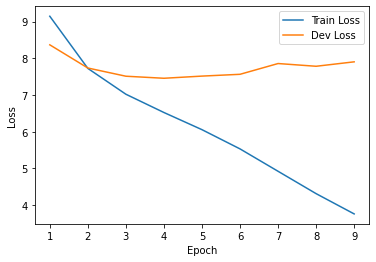

In [25]:
import matplotlib.pyplot as plt

t = list(range(1, 10))
plt.plot(t, train_losses, label="Train Loss")
plt.plot(t, dev_losses, label="Dev Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


학습 데이터 셋에 Overfitting이 일어나는 것을 확인할 수 있다.

## Answer Inference
모델의 Output을 활용해서 질문의 답을 찾는 코드를 작성하자.

In [37]:
model = BertForQuestionAnswering.from_pretrained('/content/drive/MyDrive/k-digital-goorm-3-korean-mrc/dump/model.10')
model.cuda()
model.eval()

OSError: ignored

In [29]:
for idx, sample in zip(range(1, 4), indexed_train_dataset):
    print(f'------{idx}------')
    print('Context:', sample['context'])
    print('Question:', sample['question'])
    
    input_ids, token_type_ids = [
        torch.tensor(sample[key], dtype=torch.long, device="cuda")
        for key in ("input_ids", "token_type_ids")
    ]
    
    with torch.no_grad():
        start_logits, end_logits = model(input_ids=input_ids[None, :], token_type_ids=token_type_ids[None, :])
    start_logits.squeeze_(0), end_logits.squeeze_(0)
    
    start_prob = start_logits[token_type_ids.bool()][1:-1].softmax(-1)
    end_prob = end_logits[token_type_ids.bool()][1:-1].softmax(-1)
    probability = torch.triu(start_prob[:, None] @ end_prob[None, :])
    index = torch.argmax(probability).item()
    
    start = index // len(end_prob)
    end = index % len(end_prob)
    
    start = sample['position'][start][0]
    end = sample['position'][end][1]

    print('Answer:', sample['context'][start:end])

------1------
Context: 사회적 지분급여나 사회적 인출권은 모든 이에게 일정하게 제공되는 기본적인 자원이 있어야 한다는 개념인데 비해서, 사회보험제도는 보험가입이력을 통해서 수급권을 확보하는 제도이다. 보험가입이력은 근로이력과 긴밀하게 연동되며, 무엇보다 임금노동자와 고용주의 기여가 중심이 된다. 이러한 특징은 전통적인 노동자계급의 규모와 비중이 축소되는 환경에서는 효과적인 사회적 보호 수단이 되기 어렵다. 모든 이에게 같은 금액을 지급하는 소득보장제도를 관대하게 운영하는 것은 재원마련 측면에서 어려울 뿐 아니라, 현 시점에서 사회적인 동의를 얻는 것도 쉽지 않다. 나아가 근로소득세와 사회보험료를 납부하면서 소득활동을 해 온 사람에게 최소한의 생활수준을 유지할 수 있게 해주는 보험기능의 필요성을 부인하기는 어렵다. 요컨대 사회보험 방식의 소득보장제도를 전면 폐지하고 다른 제도로 대체하는 것은 바람직하지 않다. 그러나 우리는 노동시장 환경변화로 인하여 사회보험제도가 과거와는 다른 방식으로 운영되어야 한다는 시대적 요구에 직면해 있다. 변화의 방향은 크게 두 방향을 가리키고 있다. 첫째는 보호대상을 전체 취업자로 확대하고 임금노동자와 자영자의 보호 방식을 일치시키는 것이다. 둘째는 보호해야할 사회적 위험(사건)의 범주를 확대하는 것이다.
Question: 보험 취득 서류를 통해서 수급권을 가져오는 제도는 어떤 것이지
Answer: 사회적 지분급여나 사회적 인출권은 모든 이에게 일정하게 제공되는 기본적인 자원이 있어야 한다는 개념인데 비해서, 사회보험제도는 보험
------2------
Context: 부처 시책별로 다원화되어 있던 지방자치단체 평가를 통합하여 고도화된 평가체계를 구축함으로써 중앙 및 지방자치단체의 평가부담을 완화하였다. 국정의 통합성을 확보하는 한편 평가의 투명성 공정성 신뢰성을 높여 평가결과에 대한 지방자치단체의 수용성도 높일 수 있었다. 2008년 이전(’01~’07년)의 합동평가는 평가전문 연구기관인 한국지방행정연구원에 위탁용

## Test 출력 파일 작성

In [34]:
test_dataset = TokenizedKoMRC.load([drive_path + 'test.json'], 0)
test_dataset = IndexerWrappedDataset(test_dataset, indexer)
print("Number of Test Samples", len(test_dataset))
print(test_dataset[0])

Number of Test Samples 4005
{'guid': 'd14cb73158624cf094c546d856fd3c80', 'context': 'BMW 코리아(대표 한상윤)는 창립 25주년을 기념하는 ‘BMW 코리아 25주년 에디션’을 한정 출시한다고 밝혔다. 이번 BMW 코리아 25주년 에디션(이하 25주년 에디션)은 BMW 3시리즈와 5시리즈, 7시리즈, 8시리즈 총 4종, 6개 모델로 출시되며, BMW 클래식 모델들로 선보인 바 있는 헤리티지 컬러가 차체에 적용돼 레트로한 느낌과 신구의 조화가 어우러진 차별화된 매력을 자랑한다. 먼저 뉴 320i 및 뉴 320d 25주년 에디션은 트림에 따라 옥스포드 그린(50대 한정) 또는 마카오 블루(50대 한정) 컬러가 적용된다. 럭셔리 라인에 적용되는 옥스포드 그린은 지난 1999년 3세대 3시리즈를 통해 처음 선보인 색상으로 짙은 녹색과 풍부한 펄이 오묘한 조화를 이루는 것이 특징이다. M 스포츠 패키지 트림에 적용되는 마카오 블루는 1988년 2세대 3시리즈를 통해 처음 선보인 바 있으며, 보랏빛 감도는 컬러감이 매력이다. 뉴 520d 25주년 에디션(25대 한정)은 프로즌 브릴리언트 화이트 컬러로 출시된다. BMW가 2011년에 처음 선보인 프로즌 브릴리언트 화이트는 한층 더 환하고 깊은 색감을 자랑하며, 특히 표면을 무광으로 마감해 특별함을 더했다. 뉴 530i 25주년 에디션(25대 한정)은 뉴 3시리즈 25주년 에디션에도 적용된 마카오 블루 컬러가 조합된다. 뉴 740Li 25주년 에디션(7대 한정)에는 말라카이트 그린 다크 색상이 적용된다. 잔잔하면서도 오묘한 깊은 녹색을 발산하는 말라카이트 그린 다크는 장식재로 활용되는 광물 말라카이트에서 유래됐다. 뉴 840i xDrive 그란쿠페 25주년 에디션(8대 한정)은 인도양의 맑고 투명한 에메랄드 빛을 연상케 하는 몰디브 블루 컬러로 출시된다. 특히 몰디브 블루는 지난 1993년 1세대 8시리즈에 처음으로 적용되었던 만큼 이를 오마주하는 의미를 담

In [36]:
import csv

os.makedirs('out', exist_ok=True)
with torch.no_grad(), open(drive_path + 'out/baseline.csv', 'w') as fd:
    writer = csv.writer(fd)
    writer.writerow(['Id', 'Predicted'])

    rows = []
    for sample in tqdm(test_dataset, "Testing"):
        input_ids, token_type_ids = [
            torch.tensor(sample[key], dtype=torch.long, device="cuda")
            for key in ("input_ids", "token_type_ids")
        ]
    
        with torch.no_grad():
            start_logits, end_logits = model(input_ids=input_ids[None, :], token_type_ids=token_type_ids[None, :])
        start_logits.squeeze_(0), end_logits.squeeze_(0)
    
        start_prob = start_logits[token_type_ids.bool()][1:-1].softmax(-1)
        end_prob = end_logits[token_type_ids.bool()][1:-1].softmax(-1)
        probability = torch.triu(start_prob[:, None] @ end_prob[None, :])
        index = torch.argmax(probability).item()
    
        start = index // len(end_prob)
        end = index % len(end_prob)
    
        start = sample['position'][start][0]
        end = sample['position'][end][1]

        rows.append([sample["guid"], sample['context'][start:end]])
    
    writer.writerows(rows)

Testing:   0%|          | 0/4005 [00:00<?, ?it/s]